In [6]:
import os
import pickle
import json
from tqdm.auto import tqdm
import numpy as np

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sesm import get_data
from trainer import PLModel

In [4]:
EXPERIMENT_ID = 42

CLASS_DICT = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM"
}

def get_freer_gpu():
    # Run nvidia-smi command to get GPU memory info
    command = "nvidia-smi --query-gpu=memory.free,memory.total --format=csv,noheader,nounits"
    output = os.popen(command).read().strip().split('\n')

    # Parse the output to find GPU with most free memory
    max_memory = -1
    max_memory_index = -1
    for index, line in enumerate(output):
        free_memory, _ = map(int, line.split(', '))
        if free_memory > max_memory:
            max_memory = free_memory
            max_memory_index = index

    return max_memory_index

free_gpu_id = get_freer_gpu()
#free_gpu_id=0
print("select gpu:", free_gpu_id)
torch.cuda.set_device(torch.device(free_gpu_id))

select gpu: 1


In [3]:
config = json.load(open(f"configs/sleep_edf_exp{EXPERIMENT_ID}.json", "r"))
#config = json.load(open(f"configs/sleep_edf_exp17-19.json", "r"))
train_loader, val_loader, test_loader, class_weights, max_len = get_data(
    config["dataset"], "E:\s222165064", config["batch_size"],
    val_subject_ids=[0,1],
    test_subject_ids=[2,7,12]
)
config.update({"class_weights": class_weights, "max_len": max_len})

Load training set:
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4031E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4032E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4041E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4042E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4051E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4052E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4061E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4062E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4081E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4082E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4091E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4092E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4101E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4102E0.npz ...
Loading E:\s222165064\sleep_edf\prepared\fpz_cz\SC4111E0.npz ...
Loadin

In [52]:
plmodel = PLModel(stage=2, **config)
plmodel.model.load_state_dict(torch.load(f"models/trained_model_exp{EXPERIMENT_ID}.pt"))

model = plmodel.model
model.eval()
model.training

False

# Calculate Accuracy

In [53]:
y_true = []
y_pred = []

for x, y in tqdm(test_loader):
    y_hat, _, _, _ = model(x)
    y_true.append(y.detach().cpu().numpy())
    y_pred.append(y_hat.argmax(1).numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

  0%|          | 0/395 [00:00<?, ?it/s]

c:\Users\s222165064\.conda\envs\EEG-SESM\lib\site-packages\torch\nn\modules\conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


In [54]:
output_location = 'test_outputs'

os.makedirs(output_location, exist_ok=True)
os.makedirs(f"{output_location}/exp{EXPERIMENT_ID}", exist_ok=True)

with open(f'{output_location}/exp{EXPERIMENT_ID}/y_true_test.pkl','wb') as f:
    pickle.dump(y_true, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{output_location}/exp{EXPERIMENT_ID}/y_pred_test.pkl','wb') as f:
    pickle.dump(y_pred, f, protocol=pickle.HIGHEST_PROTOCOL)

Accuracy: 0.7474651457541192
Precision: 0.702069485847405
Recall: 0.7068049060129191


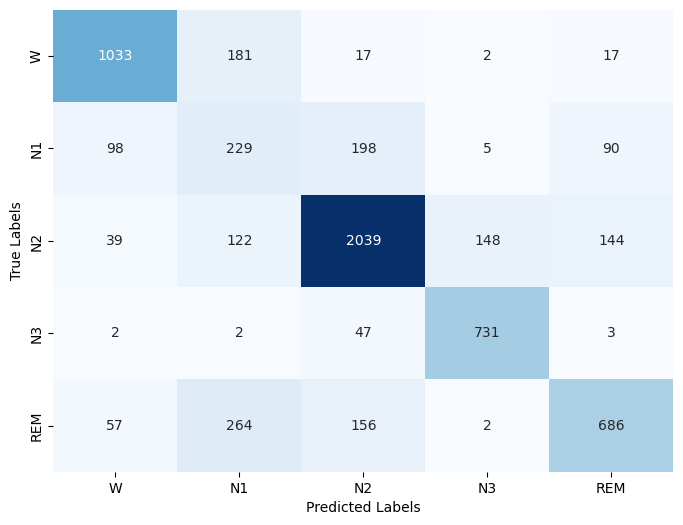

Classification Report:
              precision    recall  f1-score   support

           W       0.84      0.83      0.83      1250
          N1       0.29      0.37      0.32       620
          N2       0.83      0.82      0.82      2492
          N3       0.82      0.93      0.87       785
         REM       0.73      0.59      0.65      1165

    accuracy                           0.75      6312
   macro avg       0.70      0.71      0.70      6312
weighted avg       0.76      0.75      0.75      6312



Accuracy for W: 82.64%
Accuracy for N1: 36.94%
Accuracy for N2: 81.82%
Accuracy for N3: 93.12%
Accuracy for REM: 58.88%


In [55]:
class_names = CLASS_DICT.values()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
# Create a confusion matrix
confusion = confusion_matrix(y_true, y_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.gca().set_xticklabels(class_names)
plt.ylabel('True Labels')
plt.gca().set_yticklabels(class_names)
plt.show()
# Generate a classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)
# Calculate class-wise accuracy
class_accuracy = confusion.diagonal()/confusion.sum(axis=1)
print("\n")
# Print class-wise accuracy
for i, class_name in enumerate(class_names):
    print(f'Accuracy for {class_name}: {class_accuracy[i]*100:.2f}%')

# Calculate APOC

In [56]:
AOPC = torch.zeros(config['n_heads'])
total = 0

for x,y in tqdm(test_loader):
    y_hat_, _, selective_actions, relevance_weights = model(x, x != 0,ignore_relevance_weights=True) 
    batch_size = x.shape[0]
    
    relevance_weights = relevance_weights.detach().cpu()
    y_hat_ = y_hat_.detach().reshape(batch_size, config['n_heads'], -1).cpu()
    
    attn_arg = torch.sort(relevance_weights, 1, descending=True)[1] 
    
    attn_logits = y_hat_ * relevance_weights.unsqueeze(-1)
    
    for i in range(config['n_heads']):
        AOPC[i] += F.softmax(attn_logits[:, i:].sum(1), -1)[torch.arange(batch_size).long(), y.cpu().long()].sum()
        
    total += batch_size

    del x
    del y
    del y_hat_
    del relevance_weights
    del attn_arg
    del attn_logits
    # break

  0%|          | 0/395 [00:00<?, ?it/s]

In [57]:
output_location = 'test_outputs'

os.makedirs(output_location, exist_ok=True)
os.makedirs(f"{output_location}/exp{EXPERIMENT_ID}", exist_ok=True)

with open(f'{output_location}/exp{EXPERIMENT_ID}/AOPC.pkl','wb') as f:
    pickle.dump(AOPC, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{output_location}/exp{EXPERIMENT_ID}/total.pkl','wb') as f:
    pickle.dump(total, f, protocol=pickle.HIGHEST_PROTOCOL)

# Create Plots

## Kernel Size

In [17]:
experiment_ids = [33, 34, 35, 22, 36,41]
kernel_size = [10,20,30,40,50,60]

accuracies = []
f1_scores = []
aopc_scores = []

for experiment_id in experiment_ids:
    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    # Calculate AOPC
    aopc_scores.append((AOPC / total).mean())


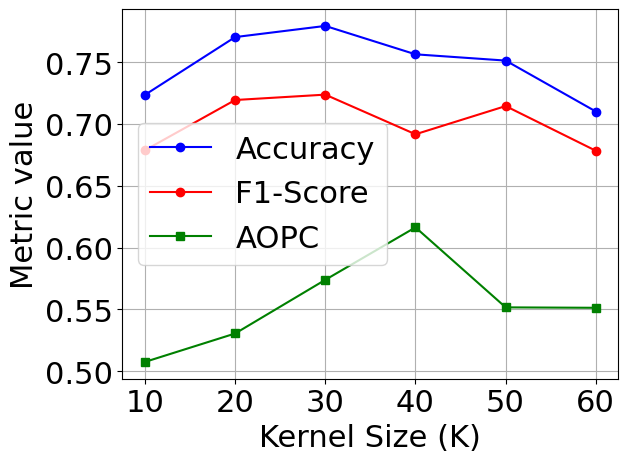

In [22]:
# Plotting

mpl.rcParams["font.size"] = 22

plt.plot(kernel_size, accuracies, marker='o', color='blue', label='Accuracy')
plt.plot(kernel_size, f1_scores, marker='o', color='red', label='F1-Score')
plt.plot(kernel_size, aopc_scores, marker='s', color='green', label='AOPC')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

# Axis labels
plt.xlabel('Kernel Size (K)')
plt.ylabel('Metric value')

# Set x-axis ticks to be integers only
plt.xticks(kernel_size)

plt.grid(True)

# Legend
plt.legend()

# Show plot
plt.show()

## Number of Heads

In [23]:
experiment_ids = [21, 22, 23, "16-2", 25, 29]
n_heads = [4,5,6,7,8,9]

accuracies = []
f1_scores = []
aopc_scores = []

for experiment_id in experiment_ids:
    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    # Calculate AOPC
    aopc_scores.append((AOPC / total).mean())


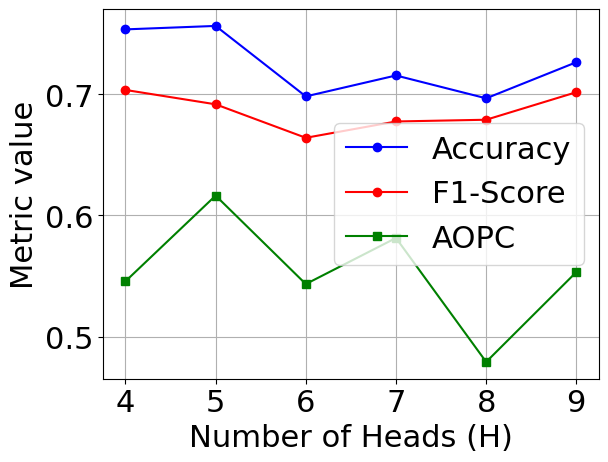

In [24]:
# Plotting
plt.plot(n_heads, accuracies, marker='o', color='blue', label='Accuracy')
plt.plot(n_heads, f1_scores, marker='o', color='red', label='F1-Score')
plt.plot(n_heads, aopc_scores, marker='s', color='green', label='AOPC')

# Axis labels
plt.xlabel('Number of Heads (H)')
plt.ylabel('Metric value')

# Set x-axis ticks to be integers only
plt.xticks(n_heads)

plt.grid(True)

# Legend
plt.legend(loc='right')

# Show plot
plt.show()

In [25]:
print(accuracies)
print(aopc_scores)

[0.7534854245880862, 0.7563371356147022, 0.6981939163498099, 0.7154626108998733, 0.6966096324461344, 0.7263941698352345]
[tensor(0.5456), tensor(0.6164), tensor(0.5434), tensor(0.5814), tensor(0.4791), tensor(0.5533)]


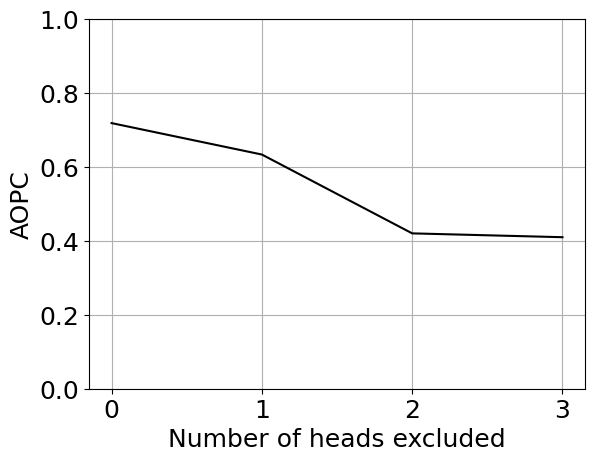

In [11]:
with open(f'test_outputs/exp21/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp21/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(4), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()


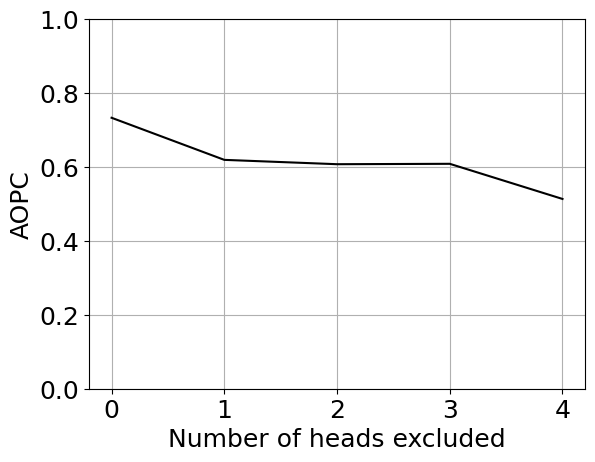

In [12]:
with open(f'test_outputs/exp22/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp22/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(5), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()

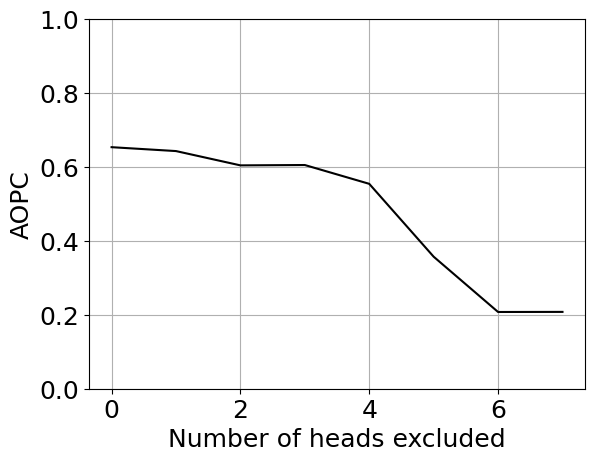

In [13]:
with open(f'test_outputs/exp25/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp25/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(8), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()


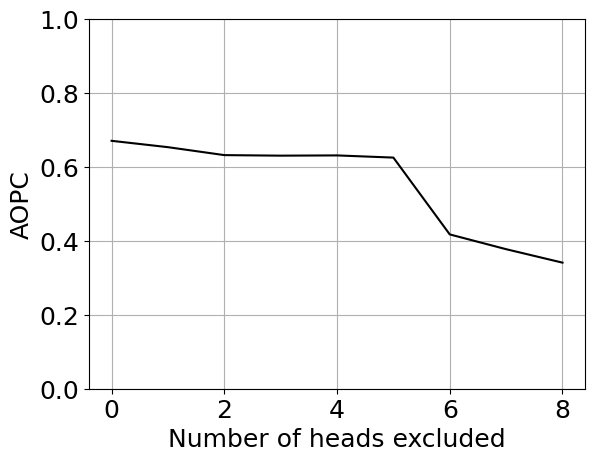

In [14]:
with open(f'test_outputs/exp29/AOPC.pkl','rb') as f:
    AOPC = pickle.load(f)

with open(f'test_outputs/exp29/total.pkl','rb') as f:
    total = pickle.load(f)

plt.plot(np.arange(9), (AOPC / total).numpy(), color='black')
plt.ylim(0,1)
plt.xlabel('Number of heads excluded')
plt.ylabel('AOPC')
plt.grid(True)
plt.show()

## Diversity

In [26]:
experiment_ids = [21, "26-2", 28, 30, 27, 42]
d_min = [2,5,7,9,10,11]

accuracies = []
f1_scores = []
aopc_scores = []

for experiment_id in experiment_ids:
    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    # Calculate AOPC
    aopc_scores.append((AOPC / total).mean())


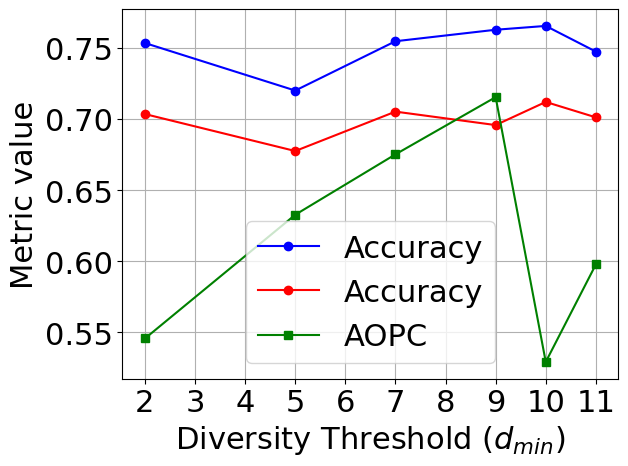

In [27]:
# Plotting

mpl.rcParams["font.size"] = 22

plt.plot(d_min, accuracies, marker='o', color='blue', label='Accuracy')
plt.plot(d_min, f1_scores, marker='o', color='red', label='Accuracy')
plt.plot(d_min, aopc_scores, marker='s', color='green', label='AOPC')

# Axis labels
plt.xlabel('Diversity Threshold ($d_{min}$)')
plt.ylabel('Metric value')

# Set x-axis ticks to be integers only
plt.xticks(range(2,12))

plt.grid(True)

# Legend
plt.legend()

# Show plot
plt.show()

## Main Results

In [4]:
class_names = CLASS_DICT.values()

# Load the experiments
#experiment_ids = [16,18,19]
experiment_ids = [37,38,39,40]
split_results = []
classwise_accuracies = []

for experiment_id in experiment_ids:

    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)

    with open(f'test_outputs/exp{experiment_id}/AOPC.pkl','rb') as f:
        AOPC = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/total.pkl','rb') as f:
        total = pickle.load(f)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    # Calculate AOPC
    aopc = (AOPC / total).mean().numpy()

    row = {
        "experiment": experiment_id,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "aopc": aopc
    }
    split_results.append(row)

    # Create a confusion matrix
    confusion = confusion_matrix(y_true, y_pred)
    class_accuracy = confusion.diagonal()/confusion.sum(axis=1)

    classwise_row = { class_name: class_accuracy[i] for i, class_name in enumerate(class_names) }
    classwise_row["experiment"] = experiment_id
    classwise_accuracies.append(classwise_row)

In [5]:
results_df = pd.DataFrame(split_results)
classwise_results = pd.DataFrame(classwise_accuracies)

display(results_df)
display(classwise_results)

,experiment,accuracy,precision,recall,aopc
0,37,0.754119,0.702193,0.695118,0.6658067
1,38,0.779795,0.688437,0.710221,0.6153941
2,39,0.757610,0.713562,0.672276,0.700739
3,40,0.697550,0.603652,0.637180,0.5337149


,W,N1,N2,N3,REM,experiment
0,0.762400,0.264516,0.864767,0.940127,0.643777,37
1,0.815877,0.295165,0.820019,0.914163,0.705882,38
2,0.636820,0.298625,0.867878,0.734475,0.823582,39
3,0.807609,0.138614,0.602931,0.864019,0.772727,40


In [6]:
(0.762400+0.264516+0.864767+0.940127+0.643777)/5

0.6951174

In [7]:
# Calculate mean and standard deviation
agg_mean = results_df.loc[[0,1,2],["accuracy","precision", "recall","aopc"]].mean()
agg_std = results_df.loc[[0,1,2],["accuracy","precision", "recall","aopc"]].std()

# Create a new dataframe for aggregation
agg_df = pd.DataFrame({'mean': agg_mean, 'std': agg_std})
display(agg_df)

,mean,std
accuracy,0.763841,0.013926
precision,0.701397,0.012581
recall,0.692538,0.019104
aopc,0.660647,0.042906


In [8]:
# Calculate mean and standard deviation
classwise_agg_mean = classwise_results.loc[[0,1,2],list(class_names)].mean()
classwise_agg_std = classwise_results.loc[[0,1,2],list(class_names)].std()

# Create a new dataframe for classwise_aggregation
classwise_agg_df = pd.DataFrame({'mean': classwise_agg_mean, 'std': classwise_agg_std})
display(classwise_agg_df)

,mean,std
W,0.738366,0.091916
N1,0.286102,0.018774
N2,0.850888,0.026779
N3,0.862922,0.111993
REM,0.724414,0.091324


In [9]:
y_trues = []
y_preds = []

for experiment_id in [37,38,39]:

    with open(f'test_outputs/exp{experiment_id}/y_true_test.pkl','rb') as f:
        y_true = pickle.load(f)
    
    with open(f'test_outputs/exp{experiment_id}/y_pred_test.pkl','rb') as f:
        y_pred = pickle.load(f)
    
    y_trues.append(y_true)
    y_preds.append(y_pred)

y_true = np.concatenate(y_trues)
y_pred = np.concatenate(y_preds)

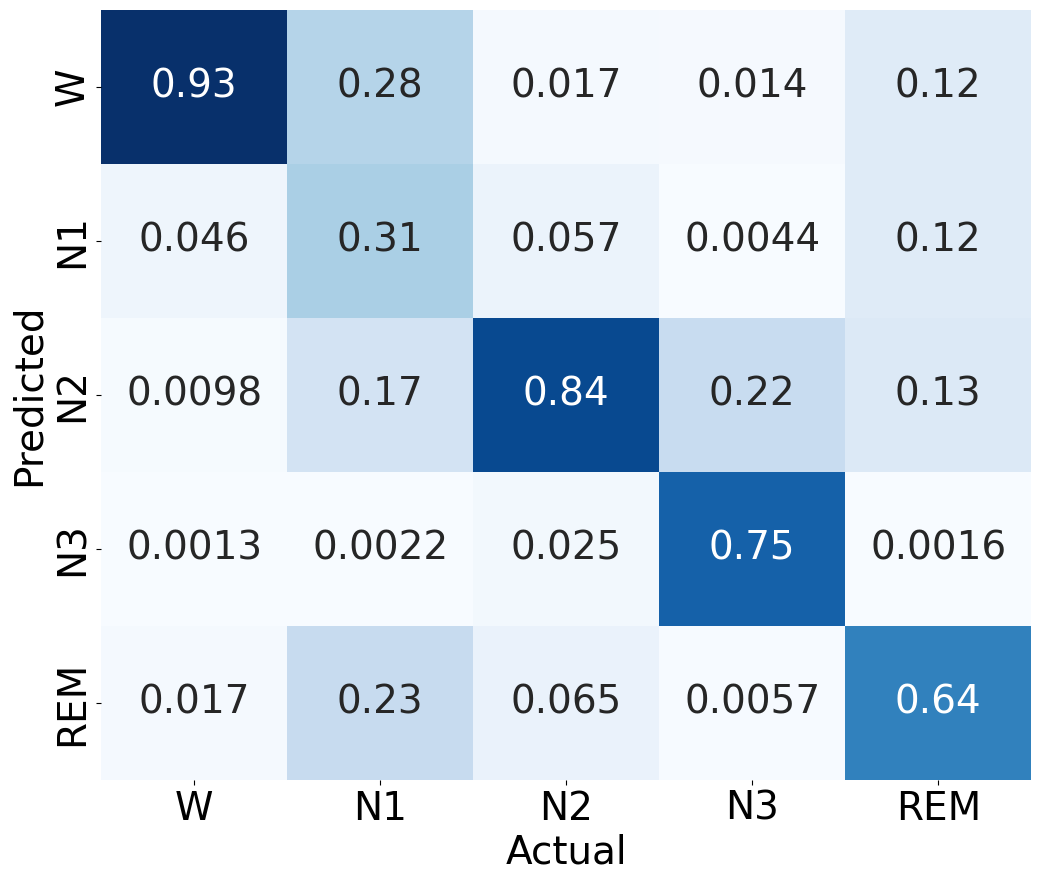

In [13]:
C = confusion_matrix(y_true, y_pred)
C = C / C.astype(float).sum(axis=0)

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    C,
    annot=True,
    annot_kws={"fontsize":28},
    cmap='Blues',
    cbar=False
)
ax.set_xticklabels(CLASS_DICT.values(), fontsize=28)
ax.set_yticklabels(CLASS_DICT.values(), fontsize=28)
ax.set_xlabel("Actual", fontsize=28)
ax.set_ylabel("Predicted", fontsize=28)
plt.show()